In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import os
import json


plt.rcParams['figure.constrained_layout.use'] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# plt.style.use(['science','ieee','vibrant'])

# Set default figure size
plt.rcParams['figure.constrained_layout.use'] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rc('axes', labelsize=9)
    
plt.style.use(['science','ieee','high-vis'])
# plt.rcParams['axes.linewidth'] = 1
# plt.rcParams['figure.dpi'] =300

w = 3.3 
h = 2.5

high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]

In [15]:
def extract_session_powers(session_lst, interval=5):
    """ 
    FORMER VERSION
    Input: session_lst, type: string 
    session dataframes power data for single session. 
    Return: 
    df of power (W) indexed with timestamp (US/Pacific)
    5 min intervals, rounded to 5 min floor
    """
    session_lst =session_lst[1:-1].split("}, {") 
    sessions_powers = []
    sessions_timestamp = []
    for elem in session_lst:
        # 0 for power 
        sessions_powers.append(elem.split(",")[0].split("'power_W': Decimal('")[-1].split("')")[0])
        # 1 for timestamp
        sessions_timestamp .append(elem.split(",")[1].split("'timestamp': Decimal('")[-1].split("')")[0])

    session_pow = pd.DataFrame(index =pd.to_datetime(pd.Series(sessions_timestamp),unit='s').dt.floor('{}min'.format(interval)) , 
                                data = {"power_w":sessions_powers})
    session_pow = session_pow.tz_localize("utc").tz_convert("US/Pacific")
    session_pow['power_w'] = session_pow['power_w'].astype(float)
    return session_pow 

def extract_session_data(df,row, interval = 5):

    """ Input: DataFrame of historical sessions 
        Everything in 5 min intervals 
    """
    
    start_interval =df.loc[row,"connectTime"].floor('5min') 
    end_interval =df.loc[row,"lastUpdate"].floor('5min') 
    duration_periods = int(df.loc[row,"DurationHrs"] * 60 / interval)
    # Create a dataframe with index from connectTime to disconnectTime time. Round down to nearest 15 minutes? 

    session_pow =  extract_session_powers(df.loc[row,"power"])
    assert (session_pow["power_w"].sum() * (interval/60)) / 1000 > 0, "Baseline Power Timestamp Mismatch"
    index = pd.date_range(start= start_interval , end =  end_interval,freq="{}min".format(interval) ,tz="US/Pacific")


    session_df = pd.DataFrame(index=index, columns = ["userId",  'reg_centsPerHr', 'sch_centsPerHr', 'sch_centsPerOverstayHr', "vehicle_maxChgRate_W","" ,"connectionStatus", "chargingStatus","overstayStatus","power_w"])


    
    assert session_pow.index[0] >= session_df.index[0], "Charging strats before connection {} >= {}".format(session_pow.index,session_df.index )

    # power_w column must be null when not charging 
    session_df["power_w"] =session_pow[~session_pow.index.duplicated()]
    session_df["userId"] = df.loc[row,"userId"]
    session_df["dcosId"] = df.loc[row,"dcosId"]
    session_df["choice"] = df.loc[row,"choice"] 
    session_df["reg_centsPerHr"] = df.loc[row,"reg_centsPerHr"] 
    session_df["sch_centsPerHr"] = df.loc[row,"sch_centsPerHr"] 
    session_df["sch_centsPerOverstayHr"] = df.loc[row,"sch_centsPerOverstayHr"] 
    session_df["vehicle_maxChgRate_W"] = df.loc[row,"vehicle_maxChgRate_W"] 
    session_df["connectionStatus"] = 1
    session_df["chargingStatus"] = (~session_df["power_w"].isnull()).astype(int)
    session_df["overstayStatus"] = 0
#     session_df["TOU (cents/kwh)"] = sessions_TOU(start_interval.date())["TOU (cents/kwh)"]
    session_df["DurationHrs"] = df.loc[row,"DurationHrs"]
    session_df['connectedDuration_Hrs'] = (df.loc[row,'lastUpdate'] - df.loc[row,'connectTime']).seconds / 3600 

    session_df['Energy_IRL'] =(float(session_pow.sum()) * (interval/60)) / 1000
    
    return session_df
# def slack_time(session_df, interval = 5):
#     return len(session_df[(session_df['connectionStatus'] == 1) & (session_df['chargingStatus'] == 0) ]) * interval


# 1. Data Cleaning

In [16]:
# Date range:  Jan.1st 2021 - Aug.26 2022 
start_date = pd.Timestamp(year=2021, month=1, day=1, hour=0)
end_date =  pd.Timestamp(year=2022, month=8, day=27, hour=0)

slrpev_path ='/Users/aysetugbaozturk/Documents/eCal/SlrpEV_algorithms-server/'
results_path = slrpev_path + "Sessions.csv"
# results_path = "Sessions.csv"

sessions = pd.read_csv(results_path)
sessions['connectTime']  = pd.to_datetime(sessions['connectTime'] )
sessions['startChargeTime']  = pd.to_datetime(sessions['startChargeTime'] )
sessions['Deadline']  = pd.to_datetime(sessions['Deadline'] )
sessions['lastUpdate']  = pd.to_datetime(sessions['lastUpdate'])

sessions = sessions[(sessions['connectTime'] >=start_date) & 
                    (sessions['connectTime'] < end_date)].sort_values(by='connectTime')


In [17]:
%%time
timestamp_error = []
power_df_list = []
interval = 5
for row in list(sessions.index):
    try:
        session_df = extract_session_data(sessions,row, interval)
        session_powers = session_df[['dcosId','power_w']].fillna(0)
        power_df_list.append(session_powers)
    except AssertionError: 
        timestamp_error.append(row)

CPU times: user 18.3 s, sys: 189 ms, total: 18.5 s
Wall time: 18.9 s


In [18]:
import datetime
power_df = pd.concat(power_df_list)
power_df.reset_index(drop=False,inplace=True)
unique_days = len((power_df['index'].dt.date).unique())
print(unique_days )
power_df.reset_index(drop=False,inplace=True)
power_df['Time'] = power_df['index'].dt.time

511


In [19]:
len(sessions)

2060

In [20]:
sessions['siteId']

28      25
29      23
30      23
31      23
32      23
        ..
2083    25
2084    25
2085    25
2086    25
2087    25
Name: siteId, Length: 2060, dtype: int64

In [21]:
# 1. peakPower_W = 0 and cumEnergy_W = 0: delete  
sessions = sessions[(sessions["peakPower_W"]!=0) & (sessions["cumEnergy_Wh"]!=0)]
print(len(sessions))

1948


In [22]:
# 2. Fix the user peak_powers. Self-reported vehicle max charge rate may not be correct. 
# ie. they input 1kW but historically they have 6.6. 
# For the upcoming calculations, we need the possible charging rate for our station. min(vehicle rate, 6.6)
# Then we need the true vehicle power rate

user_df = sessions[['userId','peakPower_W','vehicle_maxChgRate_W']].groupby('userId').max()
user_df['session_counts'] = sessions[['userId','peakPower_W']].groupby('userId').count()

#Some users have only 1 session (44) --> just be aware of this.
validate_users = user_df[(user_df['session_counts']==1)  ].index.to_list()
user_df.reset_index(drop=False,inplace=True)
user_df.rename(columns={"peakPower_W":'historical_peakPower_w'},inplace=True)
sessions = sessions.merge(user_df[['userId','historical_peakPower_w']])
#These guys have only 1 session:
sessions[sessions['userId'].isin(validate_users)].head(5)

,dcosId,userId,vehicle_model,vehicle_maxChgRate_W,siteId,stationId,connectTime,startChargeTime,Deadline,energyReq_Wh,...,Duration,DurationHrs,choice,regular,scheduled,cumEnergy_Wh,peakPower_W,power,lastUpdate,historical_peakPower_w
484,148,709,Leaf,3300,23,8,2021-02-16 12:45:28,2021-02-16 12:45:48,NaT,NaN,...,0 days 01:04:19,1.07194,REGULAR,1,0,3933.0,4113,"[{'power_W': Decimal('4113'), 'timestamp': Dec...",2021-02-16 13:50:07,4113
539,190,633,electric drive,4000,25,18,2021-03-05 14:27:17,2021-03-05 14:27:31,NaT,NaN,...,0 days 00:37:37,0.62694,REGULAR,1,0,2058.0,3509,"[{'power_W': Decimal('3501'), 'timestamp': Dec...",2021-03-05 15:05:08,3509
545,198,675,Bolt EV,7200,25,11,2021-03-09 10:34:02,2021-03-09 10:34:28,2021-03-09 11:30:00,7059.0,...,0 days 00:10:40,0.17777,SCHEDULED,0,1,1087.0,6742,"[{'power_W': Decimal('2231'), 'timestamp': Dec...",2021-03-09 10:45:08,6742
562,259,750,Leaf,6600,23,9,2021-03-25 08:18:47,2021-03-25 08:18:59,2021-03-25 17:15:00,4667.0,...,0 days 07:21:08,7.35222,SCHEDULED,0,1,19121.0,6339,"[{'power_W': Decimal('5063'), 'timestamp': Dec...",2021-03-25 15:40:07,6339
695,307,758,Ioniq PHEV,3000,25,11,2021-04-05 09:37:57,2021-04-05 09:38:05,2021-04-05 12:30:00,8900.0,...,0 days 00:22:08,0.36888,SCHEDULED,0,1,1209.0,3540,"[{'power_W': Decimal('3523'), 'timestamp': Dec...",2021-04-05 10:00:13,3540


In [23]:
sessions["Price Difference (cents/hr)"] = sessions['reg_centsPerHr'] - sessions['sch_centsPerHr'] 
sessions[sessions["Price Difference (cents/hr)"].isnull()].iloc[:,:20]

,dcosId,userId,vehicle_model,vehicle_maxChgRate_W,siteId,stationId,connectTime,startChargeTime,Deadline,energyReq_Wh,estCost,reg_centsPerHr,sch_centsPerHr,sch_centsPerKwh,sch_centsPerOverstayHr,Duration,DurationHrs,choice,regular,scheduled
1,96,615,Model 3,170000,25,13,2021-01-08 11:07:28,2021-01-08 11:10:07,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:25:01,0.41694,REGULAR,1,0
50,2240,615,Model 3,170000,25,13,2022-03-13 15:23:55,2022-03-13 15:25:26,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0 days 05:44:40,5.74444,REGULAR,1,0
77,93,610,Bolt,7200,23,8,2021-01-07 07:37:04,2021-01-07 07:41:25,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0 days 04:43:42,4.72833,REGULAR,1,0
139,123,603,Prius Prime,8800,25,12,2021-02-02 06:33:22,2021-02-02 06:36:19,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0 days 02:43:49,2.73027,REGULAR,1,0
140,125,603,Prius Prime,8800,25,13,2021-02-03 06:06:35,2021-02-03 06:06:43,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0 days 02:08:26,2.14055,REGULAR,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,2724,1132,Model Y,7680000,25,12,2022-06-22 09:15:04,2022-06-22 09:15:33,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0 days 06:59:34,6.99277,REGULAR,1,0
1865,2752,1132,Model Y,7680000,25,12,2022-06-29 09:09:08,2022-06-29 09:09:46,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0 days 07:10:22,7.17277,REGULAR,1,0
1866,2839,1132,Model Y,7680000,25,11,2022-07-19 09:48:56,2022-07-19 09:50:33,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0 days 06:14:40,6.24444,REGULAR,1,0
1867,2929,1132,Model Y,7680000,25,12,2022-08-11 11:11:45,2022-08-11 11:12:24,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0 days 05:12:44,5.21222,REGULAR,1,0


In [27]:
sessions

,dcosId,userId,vehicle_model,vehicle_maxChgRate_W,siteId,stationId,connectTime,startChargeTime,Deadline,energyReq_Wh,...,DurationHrs,choice,regular,scheduled,cumEnergy_Wh,peakPower_W,power,lastUpdate,historical_peakPower_w,Price Difference (cents/hr)
0,86,615,Model 3,170000,25,15,2021-01-02 08:57:46,2021-01-02 08:59:03,NaT,NaN,...,6.18444,REGULAR,1,0,36485.0,6844,"[{'power_W': Decimal('2222'), 'timestamp': Dec...",2021-01-02 15:10:07,7041,-4.0
1,96,615,Model 3,170000,25,13,2021-01-08 11:07:28,2021-01-08 11:10:07,NaT,NaN,...,0.41694,REGULAR,1,0,2682.0,6948,"[{'power_W': Decimal('6943'), 'timestamp': Dec...",2021-01-08 11:35:08,7041,NaN
2,102,615,Model 3,170000,25,15,2021-01-16 11:18:44,2021-01-16 11:23:13,2021-01-16 13:00:00,9125.0,...,1.28166,SCHEDULED,0,1,8253.0,6840,"[{'power_W': Decimal('6773'), 'timestamp': Dec...",2021-01-16 12:40:07,7041,-16.0
3,108,615,Model 3,170000,25,12,2021-01-22 15:28:40,2021-01-22 15:29:29,NaT,NaN,...,0.76111,REGULAR,1,0,4875.0,6851,"[{'power_W': Decimal('199'), 'timestamp': Deci...",2021-01-22 16:15:09,7041,-12.0
4,119,615,Model 3,170000,25,13,2021-01-28 12:35:37,2021-01-28 12:36:36,2021-01-28 13:45:00,3802.0,...,0.64222,SCHEDULED,0,1,3498.0,6953,"[{'power_W': Decimal('6945'), 'timestamp': Dec...",2021-01-28 13:15:08,7041,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1943,3000,1180,Model X 75 Dual,17200,25,15,2022-08-24 19:03:08,2022-08-24 19:03:46,2022-08-24 21:30:00,19091.0,...,1.68944,SCHEDULED,0,1,10416.0,6539,"[{'power_W': Decimal('4788'), 'timestamp': Dec...",2022-08-24 20:45:08,6539,224.0
1944,3008,1180,Model X 75 Dual,17200,25,13,2022-08-25 18:39:51,2022-08-25 18:40:14,2022-08-25 20:30:00,15227.0,...,2.49972,SCHEDULED,0,1,10736.0,6207,"[{'power_W': Decimal('6160'), 'timestamp': Dec...",2022-08-25 21:10:13,6539,224.0
1945,3001,1189,Bolt EUV,55000,25,16,2022-08-25 08:00:52,2022-08-25 08:01:01,2022-08-25 12:15:00,22189.0,...,4.15333,SCHEDULED,0,1,13170.0,6852,"[{'power_W': Decimal('6826'), 'timestamp': Dec...",2022-08-25 12:10:13,6852,-90.0
1946,3003,1190,Rav 4 Prime,6600,25,15,2022-08-25 09:00:24,2022-08-25 09:00:34,NaT,NaN,...,3.65972,REGULAR,1,0,11384.0,3350,"[{'power_W': Decimal('3350'), 'timestamp': Dec...",2022-08-25 12:40:09,3350,-90.0


In [31]:
# SAVE SESSION DF DATA INTO CSV FILE
save_to_csv= True
fn = "sessions_cleaned.csv"
if(save_to_csv):
    sessions.to_csv (fn, index =True, header=True)

In [12]:
#Read the cleaned data
sessions = pd.read_csv("sessions_cleaned.csv")

,userId,reg_centsPerHr,sch_centsPerHr,sch_centsPerOverstayHr,vehicle_maxChgRate_W,Unnamed: 5,connectionStatus,chargingStatus,overstayStatus,power_w,dcosId,choice,DurationHrs,connectedDuration_Hrs,Energy_IRL
0,1154,287.0,127.0,400.0,4250,NaN,1,0,0,NaN,3013,SCHEDULED,4.10805,4.109722,12.072
1,1154,287.0,127.0,400.0,4250,NaN,1,1,0,3046.0,3013,SCHEDULED,4.10805,4.109722,12.072
2,1154,287.0,127.0,400.0,4250,NaN,1,1,0,3228.0,3013,SCHEDULED,4.10805,4.109722,12.072
3,1154,287.0,127.0,400.0,4250,NaN,1,1,0,3218.0,3013,SCHEDULED,4.10805,4.109722,12.072
4,1154,287.0,127.0,400.0,4250,NaN,1,1,0,3218.0,3013,SCHEDULED,4.10805,4.109722,12.072
5,1154,287.0,127.0,400.0,4250,NaN,1,1,0,3211.0,3013,SCHEDULED,4.10805,4.109722,12.072
6,1154,287.0,127.0,400.0,4250,NaN,1,1,0,3214.0,3013,SCHEDULED,4.10805,4.109722,12.072
7,1154,287.0,127.0,400.0,4250,NaN,1,1,0,3225.0,3013,SCHEDULED,4.10805,4.109722,12.072
8,1154,287.0,127.0,400.0,4250,NaN,1,1,0,3226.0,3013,SCHEDULED,4.10805,4.109722,12.072
9,1154,287.0,127.0,400.0,4250,NaN,1,1,0,3238.0,3013,SCHEDULED,4.10805,4.109722,12.072


# 2. Data Collection Period

In [57]:
plt.rcParams['figure.dpi'] =300

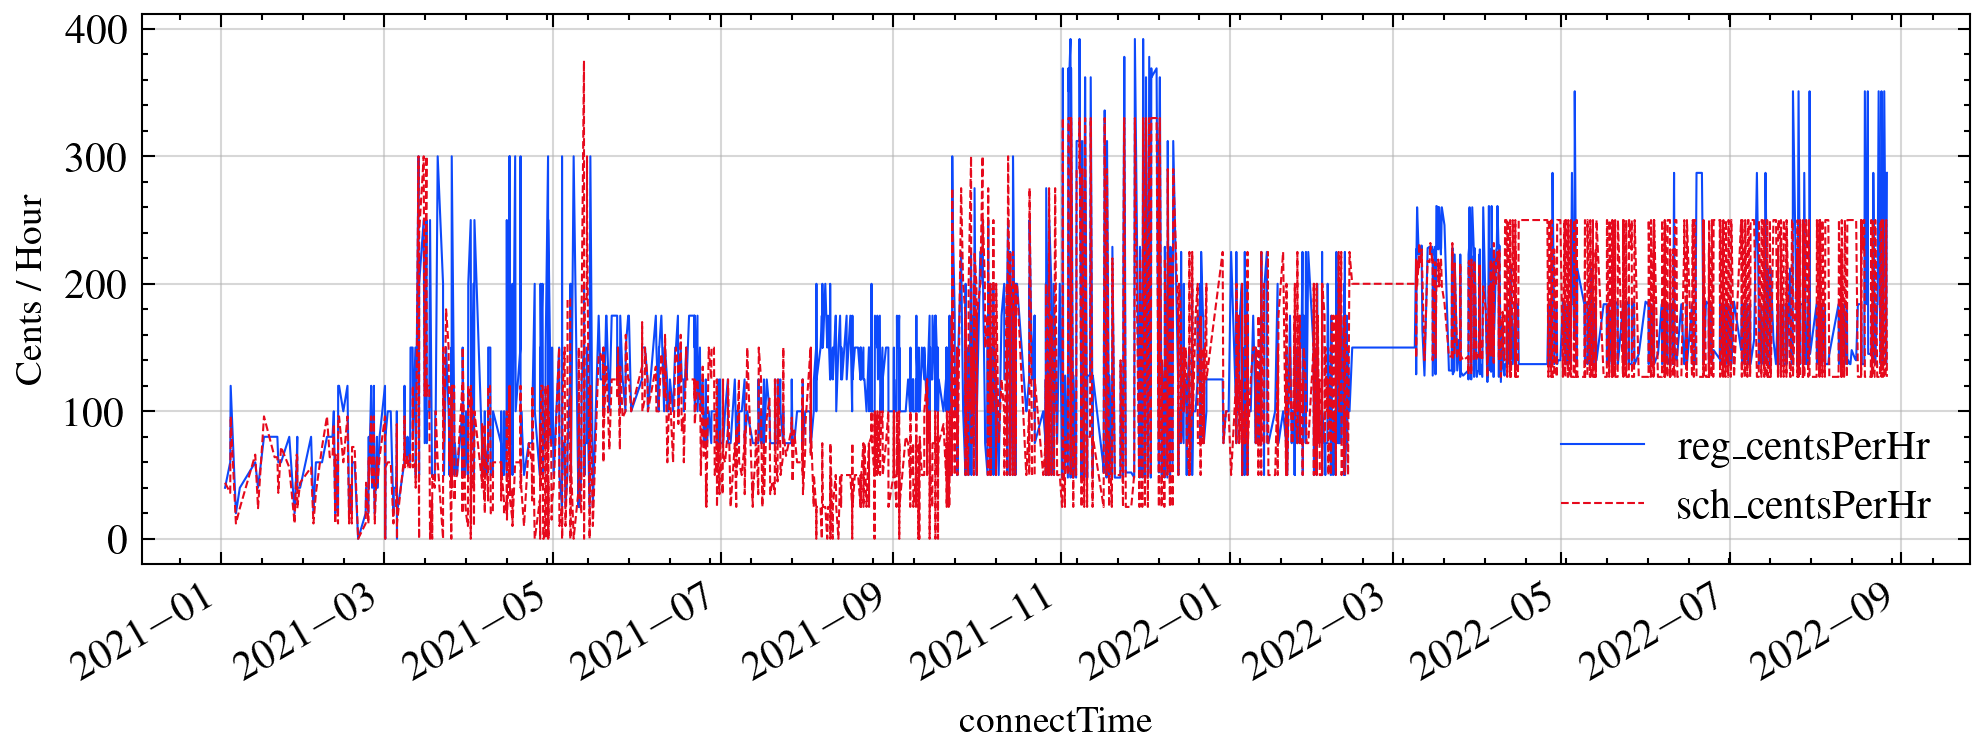

In [58]:
price_cols = ["connectTime","sch_centsPerHr","reg_centsPerHr","sch_centsPerOverstayHr"]
fig,ax= plt.subplots(1,1, figsize=(w*2,h))
sessions[price_cols].dropna().plot(x="connectTime",y=["reg_centsPerHr","sch_centsPerHr"],
                                   linewidth=0.5,ax=ax)
ax.legend(loc=4)
plt.ylabel("Cents / Hour")
plt.grid(True,alpha=0.5)

# 3. Arrival and Departure Patterns

Sessions with 0 energy delivered: 0
slack time < 0: 4


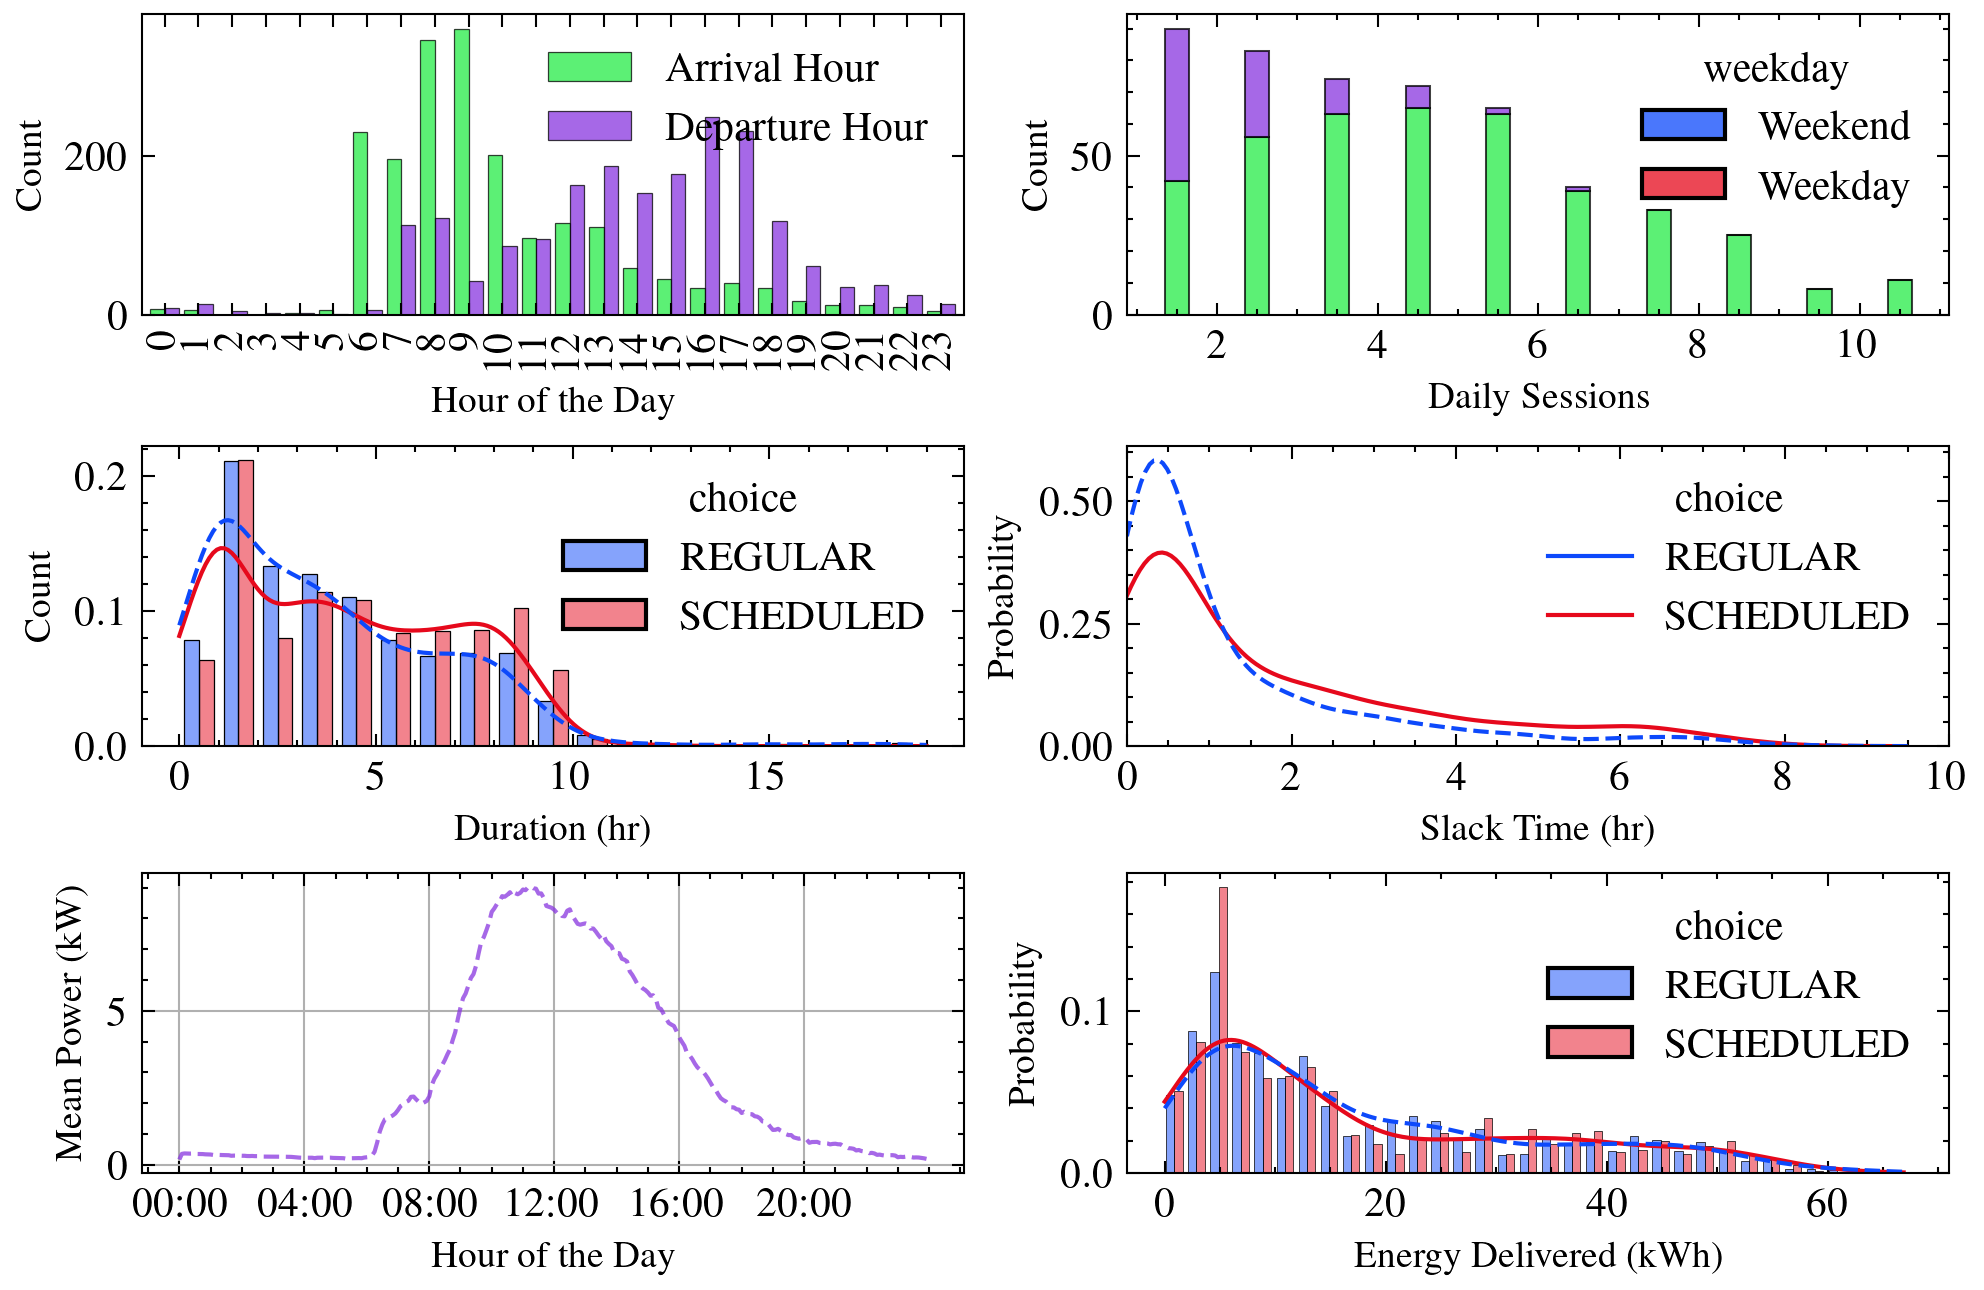

In [60]:
# Hour of the day: arrival departure 

# connectime: arrival
# departure: lastupdate 
fig,axes= plt.subplots(3,2,figsize=( w*2, 3 * h / 1.75))
sessions['Arrival Hour'] = sessions['connectTime'].dt.hour
sessions['Departure Hour'] = sessions['lastUpdate'].dt.hour

plot = pd.DataFrame(columns = ['Arrival Hour','Departure Hour'], index = range(0,24))
plot['Arrival Hour'] = sessions.groupby('Arrival Hour').count()['dcosId']
plot['Departure Hour'] = sessions.groupby('Departure Hour').count()['dcosId']
plot = plot.fillna(0)

ax=axes[0,0]
plot.plot.bar(alpha=0.75 ,ax = ax ,edgecolor='black',linewidth=0.3,
              color=[high_vis_map[2],high_vis_map[3]],width=0.85)
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Count')
ax.minorticks_off()



sessions['connectDate'] = sessions['connectTime'].dt.date
sessions['DOW'] = sessions['connectTime'].dt.weekday
daily_sessions = sessions.groupby('connectDate').count().reset_index(drop=False)
daily_sessions['dow'] = pd.to_datetime(daily_sessions['connectDate']).dt.weekday
daily_sessions['weekday'] = daily_sessions['dow'].replace({0:"Weekday",1:"Weekday",
                              2:"Weekday",3:"Weekday",
                              4:"Weekday",5:"Weekend",
                              6:"Weekend"})

sessions['Arrival Hour'] = sessions['connectTime'].dt.hour
sessions['Departure Hour'] = sessions['lastUpdate'].dt.hour

plot = pd.DataFrame(columns = ['Arrival Hour','Departure Hour'], index = range(0,24))
plot['Arrival Hour'] = sessions.groupby('Arrival Hour').count()['dcosId']
plot['Departure Hour'] = sessions.groupby('Departure Hour').count()['dcosId']
plot = plot.fillna(0)

# fig,ax= plt.subplots(1,1,figsize=( w, h/1.75 ))

ax=axes[0,1]
# multiple{“layer”, “dodge”, “stack”, “fill”}
sns.histplot(daily_sessions, x="dcosId", hue="weekday",
                   element="bars"
             ,multiple="stack", binwidth=1,shrink=0.3,legend=True,ax=ax, color = {"Weekend":high_vis_map[2],
                                                                               "Weekday":high_vis_map[3]}) # or violin, rug)

for bar, alpha in zip(ax.containers[0], 0.75 * np.ones(shape=48)):
    bar.set_alpha(alpha)
    bar.set_facecolor(high_vis_map[2])
    bar.set_edgecolor=("black")
    bar.set_linewidth=()
for bar, alpha in zip(ax.containers[1], 0.75* np.ones(shape=48)):
    bar.set_alpha(alpha)
    bar.set_facecolor(high_vis_map[3])
    bar.set_edgecolor=("black")
    bar.set_linewidth=(2)
    

    ax.set_xlabel("Daily Sessions")
ax.set_ylabel("Count")


ax=axes[1,0]

sessions['DurationHrs_bin'] = np.floor(sessions['DurationHrs'] ).astype(int)
# sessions.groupby(['DurationHrs_bin','choice']).count()['dcosId'].plot.bar(alpha=0.7,ax=ax)

sns.histplot(sessions, x="DurationHrs_bin",  hue="choice",
                                             kde = 'True',
                                             stat="probability", 
                                             common_norm=False,
                                             element="bars",
                                             multiple="dodge", 
                                             binwidth=1,
                                             shrink=0.75,
                                             legend=True,
                                             ax=ax), # or violin, rug)

ax.set_xlabel("Duration (hr)")
ax.set_ylabel('Count')

ax=axes[1,1]

sessions['cumEnergy_kWh'] = sessions['cumEnergy_Wh'] / 1000
sessions.loc[:,'historical_peakPower_kw'] = np.round(sessions.loc[:,'historical_peakPower_w'] /1000,2)
null_idx = sessions[sessions['cumEnergy_kWh']==0].index
print("Sessions with 0 energy delivered:",len(null_idx))
# fig,ax= plt.subplots(1,1,figsize=( w, h/1.75 ))
sessions['slackTime_hr'] = sessions['DurationHrs'] - sessions['cumEnergy_kWh']/sessions['historical_peakPower_kw']
sns.kdeplot(data=sessions[(sessions['slackTime_hr']<9) & (sessions['slackTime_hr']>0)], 
#              stat="probability", multiple="stack",binwidth=0.5,element="bars",
             x="slackTime_hr", hue="choice", common_norm=False,
              legend=True,ax=ax,alpha=0.7)

ax.set_xlabel('Slack Time (hr)')
ax.set_ylabel('Probability')
print("slack time < 0:", len(sessions[sessions['slackTime_hr']>10] ))

# for bar, alpha in zip(ax.containers[0], 0.7 * np.ones(shape = len(ax.containers[0]))):
#     bar.set_alpha(alpha)
# for bar, alpha in zip(ax.containers[1], 0.7 * np.ones(shape=len(ax.containers[0]))):
#     bar.set_alpha(alpha)
    
ax.set_xlim(-0,10)

ax=axes[2,0]

# Convert to kW and divide by the days
(power_df[power_df['power_w']>0].groupby('Time').sum()['power_w']/1000/unique_days).plot(color=high_vis_map[3],linestyle='--',ax=ax,alpha=0.75)
ax.grid(True)
ax.set_xticks([datetime.time(i,0) for i in np.arange(0,24,4)])
# ax.set_title('Average Power (kW)')
ax.set_ylabel('Mean Power (kW)')
ax.set_xlabel('Hour of the Day')

ax=axes[2,1]

sns.histplot(sessions, x='cumEnergy_kWh', kde=True,
                     stat="probability", 
                     common_norm=False,binwidth=2,
                     hue="choice",
#                      element="poly",
                     multiple="dodge", alpha=0.5, shrink=0.75,legend=True, ax=ax), # or violin, rug)

ax.set_ylabel('Probability')
ax.set_xlabel('Energy Delivered (kWh)')
plt.show()  


# 4. Pricing Experiments

11.827694258603351
8.758144671452236


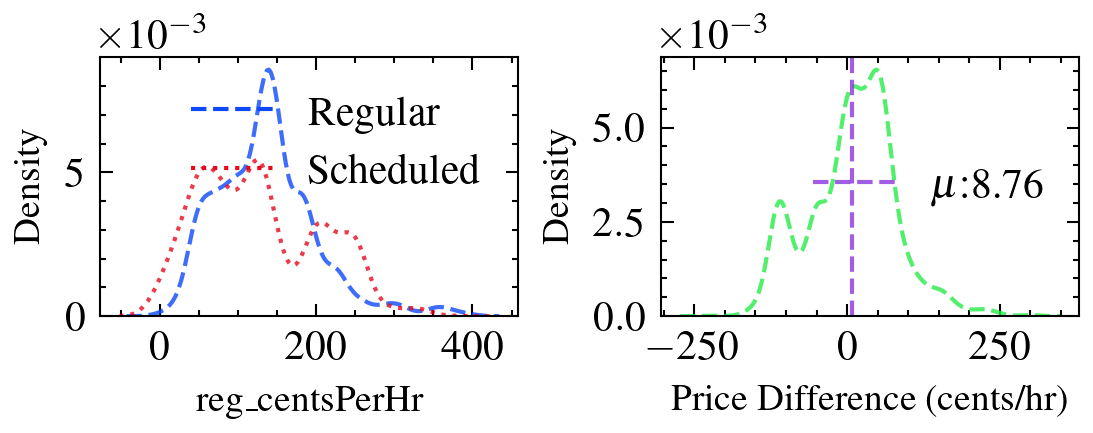

In [61]:
sessions['connectDate'] = sessions['connectTime'].dt.date

print(sessions.groupby('connectDate').mean()['Price Difference (cents/hr)'].mean())

print(sessions['Price Difference (cents/hr)'].mean())

fig,axes= plt.subplots(1,2,figsize=( w*1.1, h/1.75 ))

df_plot = pd.melt(sessions, id_vars='dcosId', value_vars=['reg_centsPerHr','sch_centsPerHr'])
df_plot['variable']  = df_plot['variable'].replace({'reg_centsPerHr':"Regular Tariff", 
                         'sch_centsPerHr': "Scheduled Tariff"})

ax =axes[0]
sns.kdeplot(sessions['reg_centsPerHr'] , ax =ax,common_norm=False, label='Regular',color=high_vis_map[0],alpha=0.7)
sns.kdeplot(sessions['sch_centsPerHr'] , ax =ax,common_norm=False, label='Scheduled',color=high_vis_map[1],alpha=0.7)
ax.legend()
for line in ax.get_lines():
    line.set_alpha(0.8)
formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 
mean_d=sessions['Price Difference (cents/hr)'].mean()
ax =axes[1]
sns.kdeplot(sessions['Price Difference (cents/hr)'],
            label = '', ax =ax,color=high_vis_map[2])
ax.axvline(mean_d, linestyle="--", color =high_vis_map[3], label = '$\mu$:{}'.format(np.round(mean_d,2)))
for line in ax.get_lines():
    line.set_alpha(0.8)
ax.legend()
formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 


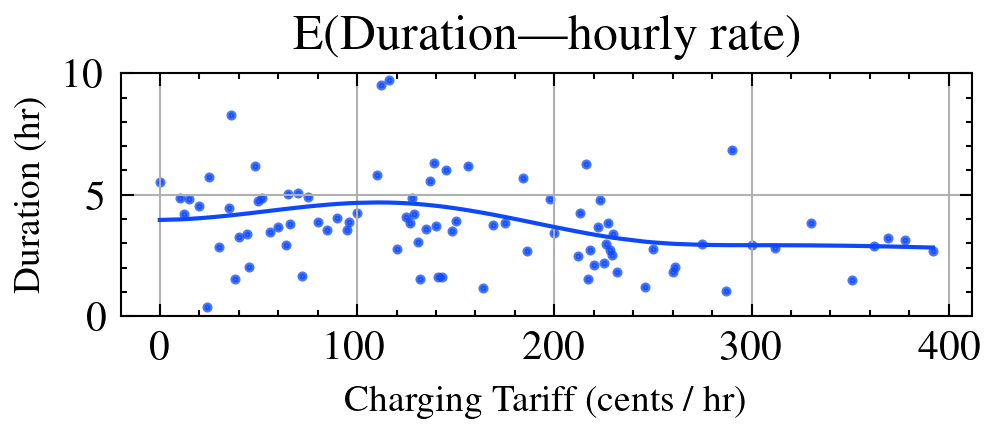

In [62]:
from statsmodels.nonparametric.kernel_regression import KernelReg

## Create grouped dataframe
duration_df = sessions.copy()
duration_df.drop(index=2,inplace=True)
# duration_df = duration_df[duration_df['DurationHrs']<=14]
duration_df['hourly_rate_cents'] = ((duration_df['choice']=='REGULAR')*(duration_df['reg_centsPerHr'])+
                                     (duration_df['choice']=='SCHEDULED')*
                                    (duration_df['sch_centsPerHr'])).astype(float)


duration_df_grouped = duration_df.groupby('hourly_rate_cents')['DurationHrs'].mean().sort_index().reset_index()

## Fit Kernel Regression
kde = KernelReg(exog=duration_df_grouped['hourly_rate_cents'], 
                endog=duration_df_grouped['DurationHrs'], var_type='c', bw=[60])


estimator = kde.fit(duration_df_grouped['hourly_rate_cents'])

predicted_values = estimator[0]


fig,ax= plt.subplots(1,1,figsize=( w, h/1.75 ))
ax.plot(duration_df_grouped['hourly_rate_cents'], 
       predicted_values)

ax.scatter(x=duration_df_grouped['hourly_rate_cents'], y = duration_df_grouped['DurationHrs'] ,s=2,alpha=.75)
ax.set_xlabel('Charging Tariff (cents / hr)')
ax.set_ylabel('Duration (hr)')
plt.ylim([0, 10]) 
plt.title('E(Duration|hourly rate)')
plt.grid(True)


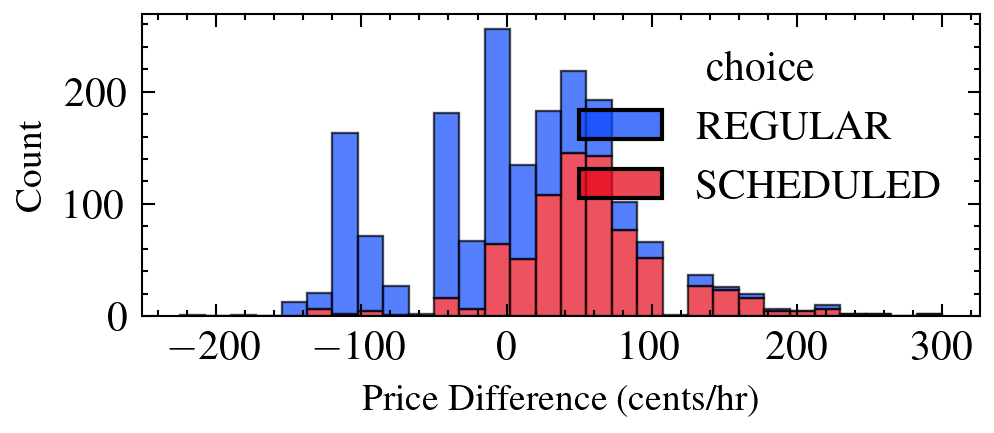

In [63]:
# Choice analysis
import plotly.express as px

fig,ax= plt.subplots(1,1,figsize=( w, h/1.75 ))


# Plot distribution of choices
sns.histplot(sessions, x="Price Difference (cents/hr)", hue="choice",
                   element="bars",multiple="stack", legend=True, ax=ax), # or violin, rug)

for bar, alpha in zip(ax.containers[0], 0.7 * np.ones(shape=48)):
    bar.set_alpha(alpha)
for bar, alpha in zip(ax.containers[1], 0.7 * np.ones(shape=48)):
    bar.set_alpha(alpha)
    

Text(0, 0.5, '')

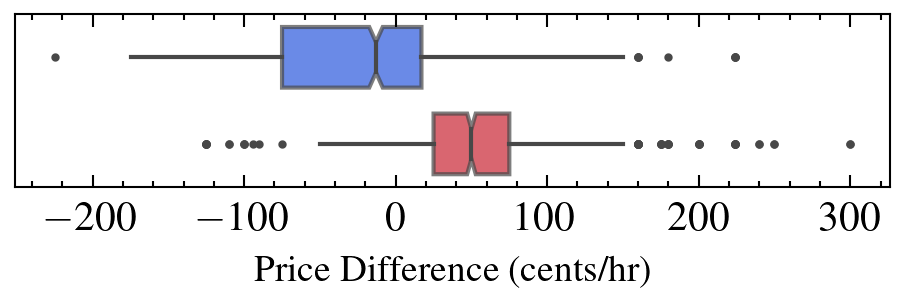

In [64]:
fig,ax= plt.subplots(1,1,figsize=( w/1.1, h/2.5 ))

flierprops = dict(marker='o', markerfacecolor='green', markersize=12)
sns.boxplot(
    data=sessions, x="Price Difference (cents/hr)", y='choice',width=0.7,
    flierprops={"marker": "o", "markersize":1},
    boxprops={"alpha": (0.7)}, 
    notch=True, showcaps=False)
ax.set_yticks([])
ax.set_ylabel("")


# 5. Energy Demand and Power Profiles

Text(0.5, 0, 'Hour of the Day')

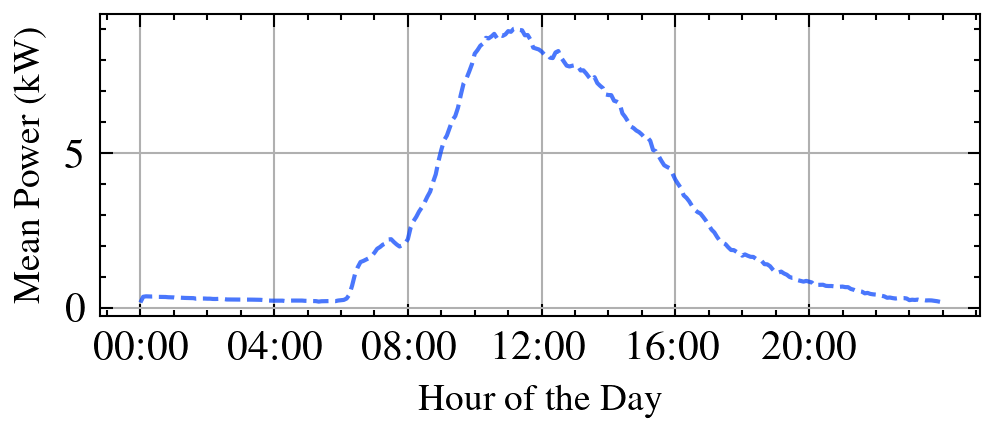

In [65]:
fig,ax= plt.subplots(1,1,figsize=( w, h/1.75 ))

(power_df[power_df['power_w']>0].groupby('Time').sum()['power_w']/1000/unique_days).plot(linestyle='--',ax=ax,alpha=0.75)
ax.grid(True)
ax.set_xticks([datetime.time(i,0) for i in np.arange(0,24,4)])
# ax.set_title('Average Power (kW)')
ax.set_ylabel('Mean Power (kW)')
ax.set_xlabel('Hour of the Day')



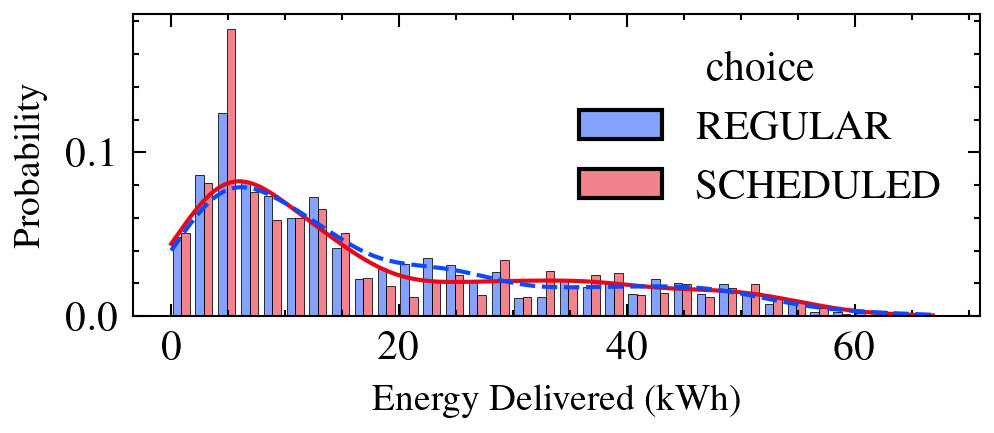

In [66]:
sessions['cumEnergy_kWh'] = np.round(sessions['cumEnergy_Wh']/1000,2)
fig,ax= plt.subplots(1,1,figsize=( w, h/1.75 ))
sns.histplot(sessions, x='cumEnergy_kWh', kde=True,
                     stat="probability", 
                     common_norm=False,binwidth=2,
                     hue="choice",
#                      element="poly",
                     multiple="dodge", alpha=0.5, shrink=0.75,legend=True, ax=ax), # or violin, rug)
# sns.kdeplot(data=sessions[(sessions['slackTime_hr']<9) & (sessions['slackTime_hr']>0)], 
# #              stat="probability", multiple="stack",binwidth=0.5,element="bars",
#              x="cumEnergy_kWh", hue="choice", common_norm=False,
#               legend=True,ax=ax,alpha=0.7)

# for bar, alpha in zip(ax.containers[0], 0.75 * np.ones(shape=48)):
#     bar.set_alpha(alpha)
# for bar, alpha in zip(ax.containers[1], 0.75 * np.ones(shape=48)):
#     bar.set_alpha(alpha)
ax.set_ylabel('Probability')
ax.set_xlabel('Energy Delivered (kWh)')
plt.show()  


# 6.User Analysis

In [67]:
# Gather data to plot and for user_df dataframe
user_cnts = sessions.groupby(by="userId").count().dcosId
user_energy = sessions.groupby(by="userId").sum().cumEnergy_Wh/1000
user_cost = sessions.groupby(by="userId").sum().estCost
user_duration = sessions.groupby(by="userId").sum().DurationHrs
user_reg = sessions.groupby(by="userId").sum().regular
user_sch = sessions.groupby(by="userId").sum().scheduled
user_slack = sessions.groupby(by="userId")['slackTime_hr'].mean()

user_arrival_departure_df = sessions[['userId','connectTime','lastUpdate']]
arrivalTime = user_arrival_departure_df['connectTime'].astype('datetime64').dt.hour + (user_arrival_departure_df['connectTime'].astype('datetime64').dt.minute)/60
departureTime = user_arrival_departure_df['lastUpdate'].astype('datetime64').dt.hour + (user_arrival_departure_df['lastUpdate'].astype('datetime64').dt.minute)/60
user_arrival_departure_df.insert(3, "arrivalTime", arrivalTime, True)
user_arrival_departure_df.insert(4, "departureTime", departureTime, True)
# print(user_arrival_departure_df)
user_arrival = user_arrival_departure_df.groupby(by="userId").median().arrivalTime
user_departure = user_arrival_departure_df.groupby(by="userId").median().departureTime
# print(user_departure)
# arrival_df = sessions['connectTime'].astype('datetime64')

user_energyPerSession = user_energy/user_cnts
user_costPerSession = user_cost/user_cnts
user_HrsPerSession = user_duration/user_cnts

user_USDperkWh = user_cost/user_energy
user_USDperHr = user_cost/user_duration

user_FractionReg = user_reg/user_cnts
user_FractionSch = user_sch/user_cnts

user_model = sessions.groupby(by="userId").first().vehicle_model
# user_email = sessions.groupby(by="userId").first().user_email


# Aggregate data into dataframe
user_df = pd.concat([user_cnts, user_energy, user_cost, user_duration, user_slack, user_energyPerSession, user_costPerSession, user_HrsPerSession, user_USDperkWh, user_USDperHr, user_arrival, user_departure, user_FractionReg, user_FractionSch, user_model], axis=1).sort_values(by=['dcosId'],ascending=False)
user_df = user_df.rename(columns={"dcosId":"SessionCount"})
user_df = user_df.rename(columns={"cumEnergy_Wh":"cumEnergy_kWh"})
user_df = user_df.rename(columns={"slackTime_hr":"slack_hr_avg"})
user_df = user_df.rename(columns={0:"EnergyPerSession_kWh"})
user_df = user_df.rename(columns={1:"CostPerSession_USD"})
user_df = user_df.rename(columns={2:"HrsPerSession"})
user_df = user_df.rename(columns={3:"USDperkWh"})
user_df = user_df.rename(columns={4:"USDperHr"})
user_df = user_df.rename(columns={5:"FractionReg"})
user_df = user_df.rename(columns={6:"FractionSch"})
user_df = user_df.rename(columns={"arrivalTime":"medianArrivalTime"})
user_df = user_df.rename(columns={"departureTime":"medianDepartureTime"})
user_df.reset_index(inplace=True)

user_df['userId'] = user_df['userId'].astype(str)

1985


(0.0, 320.0)

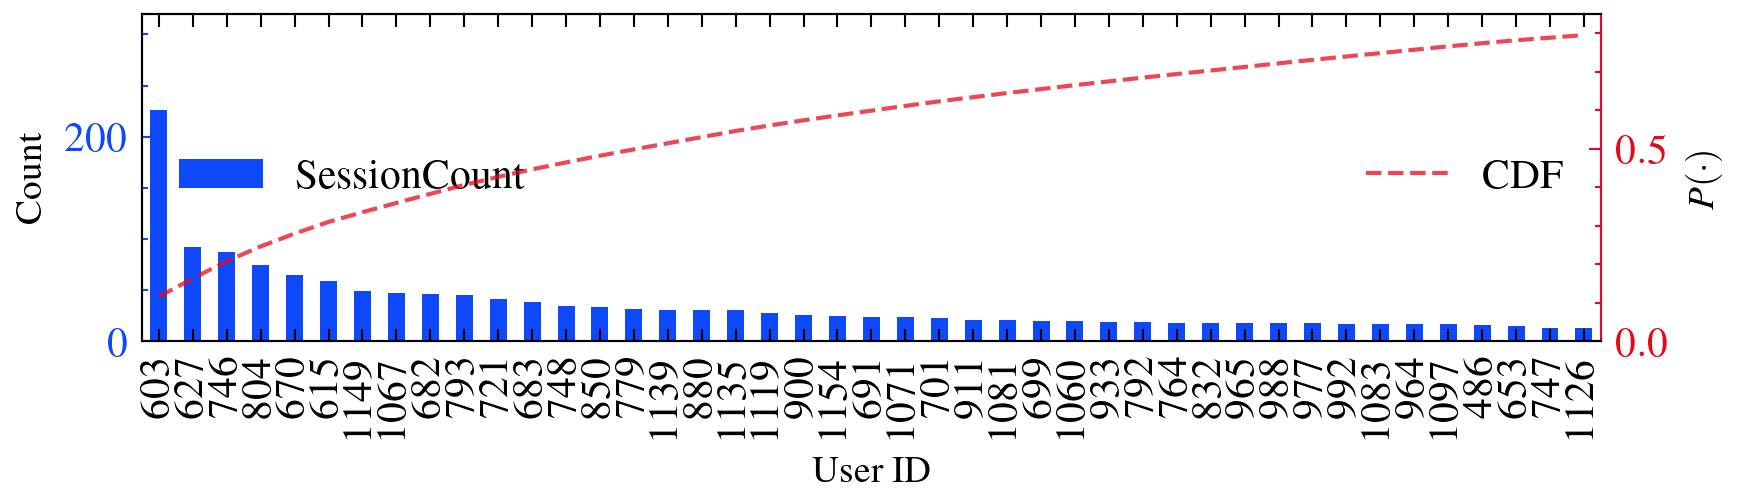

In [69]:
session_ids = power_df['dcosId'].unique()
print(len(power_df['dcosId'].unique()))
user_df = user_df.sort_values(by='SessionCount',ascending=False)
total_sessions = user_df['SessionCount'].sum()
user_df['p_user'] = user_df['SessionCount']/total_sessions
user_df['cdf_user'] = user_df['p_user'].cumsum()

fig,ax= plt.subplots(1,1,figsize=( w * 1.75, h/1.5 ))

# plot below 
plot_df = user_df[user_df['cdf_user'] <= 0.80][['userId','SessionCount','cdf_user']]

ax_cdf = ax.twinx()
ax_cdf.plot(plot_df['userId'],plot_df['cdf_user'],color = "#e6091c",linestyle="--", label = 'CDF', alpha=0.75)
ax_cdf.set_ylabel("$P(\cdot)$")
ax_cdf.set_xlabel("User ID")
ax_cdf.legend(loc=5)
ax_cdf.tick_params(axis='y', colors= "#e6091c", which='both')
ax_cdf.spines['right'].set_color("#e6091c")
# ax_cdf.yaxis.grid(True,alpha=0.75)
ax_cdf.set_ylim(0,0.85)


plot_df[['userId','SessionCount']].set_index('userId').plot.bar(ax=ax)
ax.set_ylabel("Count")
ax.set_xlabel("User ID")
ax.legend(loc=6)
ax.tick_params(axis='y', colors="#0d49fb", which='both')
ax.spines['right'].set_color("#0d49fb")
ax.margins(0.5) 
ax.xaxis.set_tick_params(which='minor',bottom=False,top=False)
# ax.xaxis.set_tick_params(which='major',bottom=False,top=False)
ax.set_ylim(0,320)


In [21]:
print("Users with 1 sessions:",len(user_df[user_df['SessionCount']==1]))
print("Users beyond 0.8 cdf:",len(user_df[user_df['cdf_user'] > 0.8]))

Users with 1 sessions: 44
Users beyond 0.8 cdf: 116


In [76]:
# Extract subset of columns for analysis
user_cluster_df = user_df[user_df['SessionCount'] >= 3]
user_cluster_df = user_cluster_df[user_cluster_df['CostPerSession_USD'] <= 15]
user_cluster_df = user_cluster_df[['userId',
                                   'EnergyPerSession_kWh',
                                   'CostPerSession_USD',
                                   'HrsPerSession',
                                   'slack_hr_avg',
                                   'medianArrivalTime',
                                   'FractionReg']] #0,1,5,6,7,10,12
user_cluster_df = user_cluster_df.set_index('userId')
print(user_cluster_df.describe())

       EnergyPerSession_kWh  CostPerSession_USD  HrsPerSession  slack_hr_avg  \
count             98.000000           98.000000      98.000000     98.000000   
mean              17.028648            5.322155       4.372155      1.629677   
std               11.509609            3.107120       1.918051      1.373180   
min                0.015000            0.000000       1.175827      0.103991   
25%                7.785250            3.311482       2.913158      0.636344   
50%               12.886404            5.161966       4.066607      1.193756   
75%               24.187951            7.240865       5.806605      2.158899   
max               46.226600           14.444391       8.971940      7.229646   

       medianArrivalTime  FractionReg  
count          98.000000    98.000000  
mean           10.992177     0.645591  
std             3.067547     0.323876  
min             6.366667     0.000000  
25%             8.943750     0.333333  
50%             9.908333     0.666667  

       EnergyPerSession_kWh  CostPerSession_USD  HrsPerSession  slack_hr_avg  \
count             98.000000           98.000000      98.000000     98.000000   
mean               0.083826            0.087350       0.092581      0.077413   
std                0.056658            0.050996       0.040615      0.065229   
min                0.000074            0.000000       0.024898      0.004940   
25%                0.038324            0.054350       0.061687      0.030228   
50%                0.063435            0.084721       0.086111      0.056706   
75%                0.119068            0.118841       0.122956      0.102552   
max                0.227557            0.237069       0.189983      0.343422   

       medianArrivalTime  FractionReg  
count          98.000000    98.000000  
mean            0.097333     0.090383  
std             0.027163     0.045343  
min             0.056376     0.000000  
25%             0.079195     0.046667  
50%             0.087736     0.093334  

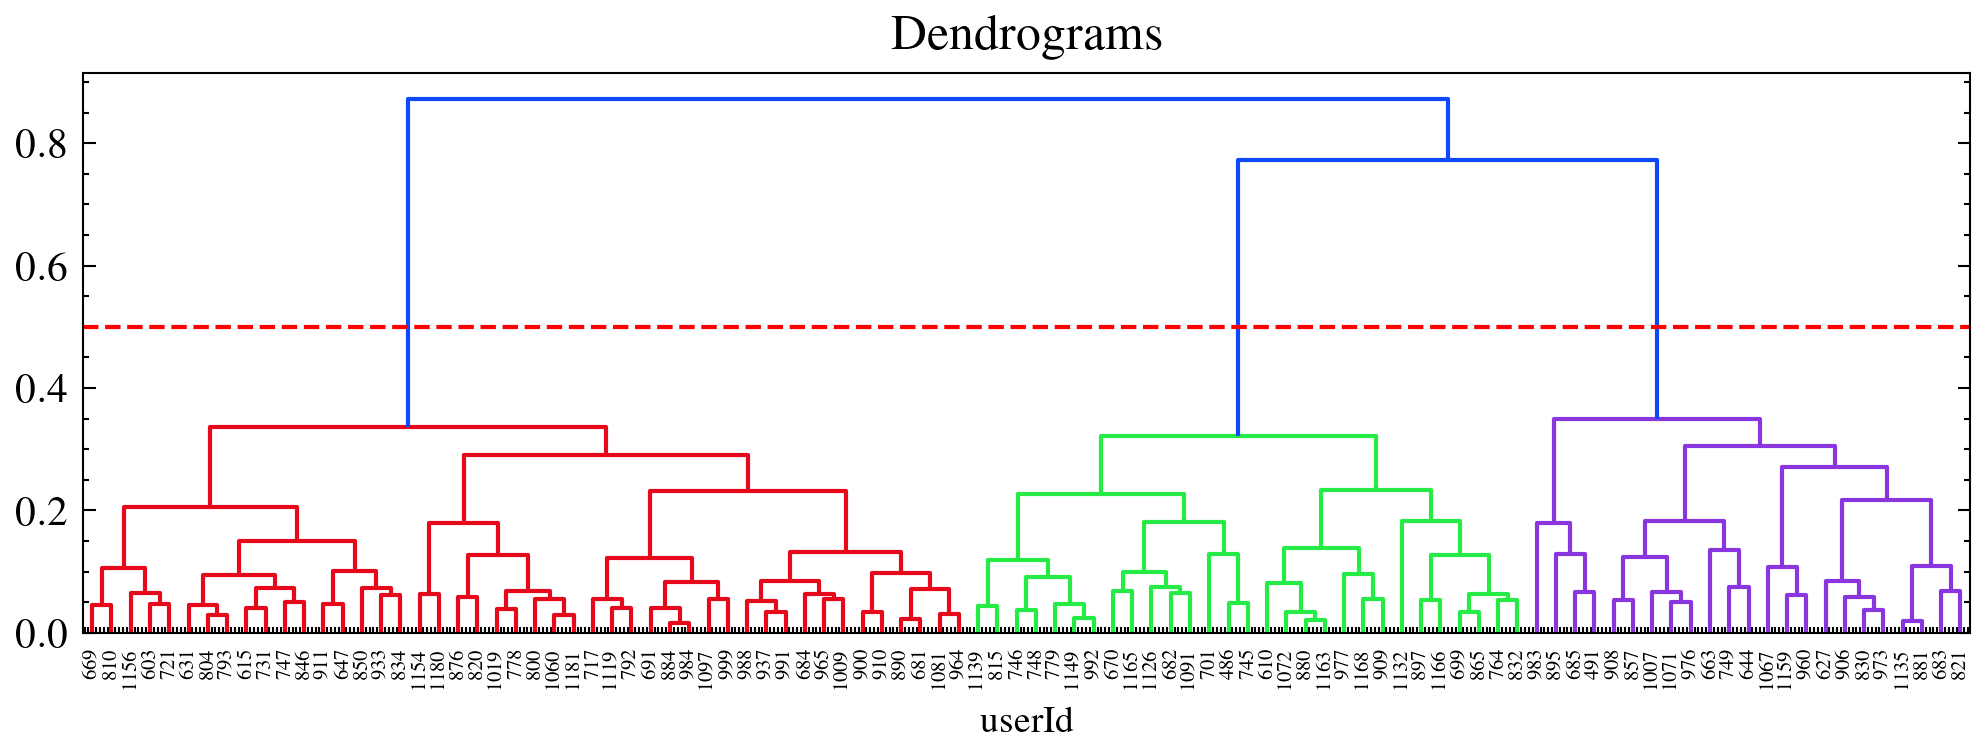

In [77]:
# Normalize data
from sklearn.preprocessing import normalize
user_cluster_norm_df = normalize(user_cluster_df, norm='l2', axis=0)
user_cluster_norm_df = pd.DataFrame(user_cluster_norm_df, columns=user_cluster_df.columns)
print(user_cluster_norm_df.describe())

# Plot Dendogram
import scipy.cluster.hierarchy as shc
fig = plt.figure(figsize=(w*2,h))  
plt.title("Dendrograms")
plt.xlabel('userId')
dend = shc.dendrogram(shc.linkage(user_cluster_norm_df, method='ward'), labels=user_cluster_df.index)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
plt.axhline(y=0.5, color='r', linestyle='--')
# dend.minorticks_off()


In [78]:
# Perform agglomerative clustering
import itertools
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(user_cluster_norm_df)
# Add columns to dataframe for plotting purposes
user_cluster_df['userId'] = user_cluster_df.index

emails = []
models = []
sessioncnts = []
for idx, row in user_cluster_df.iterrows():
#     email = user_df[user_df['userId'] == row['userId']]['user_email'].values[0]
#     emails.append(email)
    model = user_df[user_df['userId'] == row['userId']]['vehicle_model'].values[0]
    models.append(model)
    cnt = user_df[user_df['userId'] == row['userId']]['SessionCount'].values[0]
    sessioncnts.append(cnt)

# user_cluster_df['user_email'] = emails
user_cluster_df['vehicle_model'] = models
user_cluster_df['SessionCount'] = sessioncnts
user_cluster_df['cluster'] = list(map(str,cluster.labels_))

name_dict = {"medianArrivalTime":"Median\nArrival Time", 
             "EnergyPerSession_kWh":"Energy Per Session\n(kWh)", 
             "CostPerSession_USD":"Cost Per Session\n(USD)", 
             "HrsPerSession":"Duration Per Session\n(Hrs)", 
             "slack_hr_avg":"Average Slack Time\n(Hr)", 
             "FractionReg":"Regular Fraction"}
user_cluster_df.rename(columns=(name_dict),inplace=True)

# Plot Scatter Plot Matrix
fig = px.scatter_matrix(user_cluster_df,
    dimensions=['Energy Per Session\n(kWh)', 'Cost Per Session\n(USD)',
                   'Duration Per Session\n(Hrs)', 'Average Slack Time\n(Hr)',
                   'Median\nArrival Time', 'Regular Fraction'],
    color="cluster", symbol="cluster",color_discrete_sequence = ["#e6091c", "#26eb47",  "#25d7fd"],
    hover_data=['userId','vehicle_model','SessionCount'],
    width=1000, height=1000)
fig.update_traces(showupperhalf=False)
fig.update_layout(plot_bgcolor="rgba(0,0,0,0)")

fig.update_layout(
    {
        f"{ax}axis{n+1 if n>0 else ''}": {"showgrid": True,"gridcolor":'Gray',"showline":True, "linewidth":1, "linecolor":'black'}
        for n, ax in itertools.product(range(10), list("xy"))
    }
)

fig.show()

In [79]:
high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]
user_cluster_df["color"] = user_cluster_df["cluster"].replace({"0":"#e6091c", "1":"#26eb47", "2": "#25d7fd"})

Text(0, 0.5, 'Cost Per Session\n(USD)')

<Figure size 1800x1200 with 0 Axes>

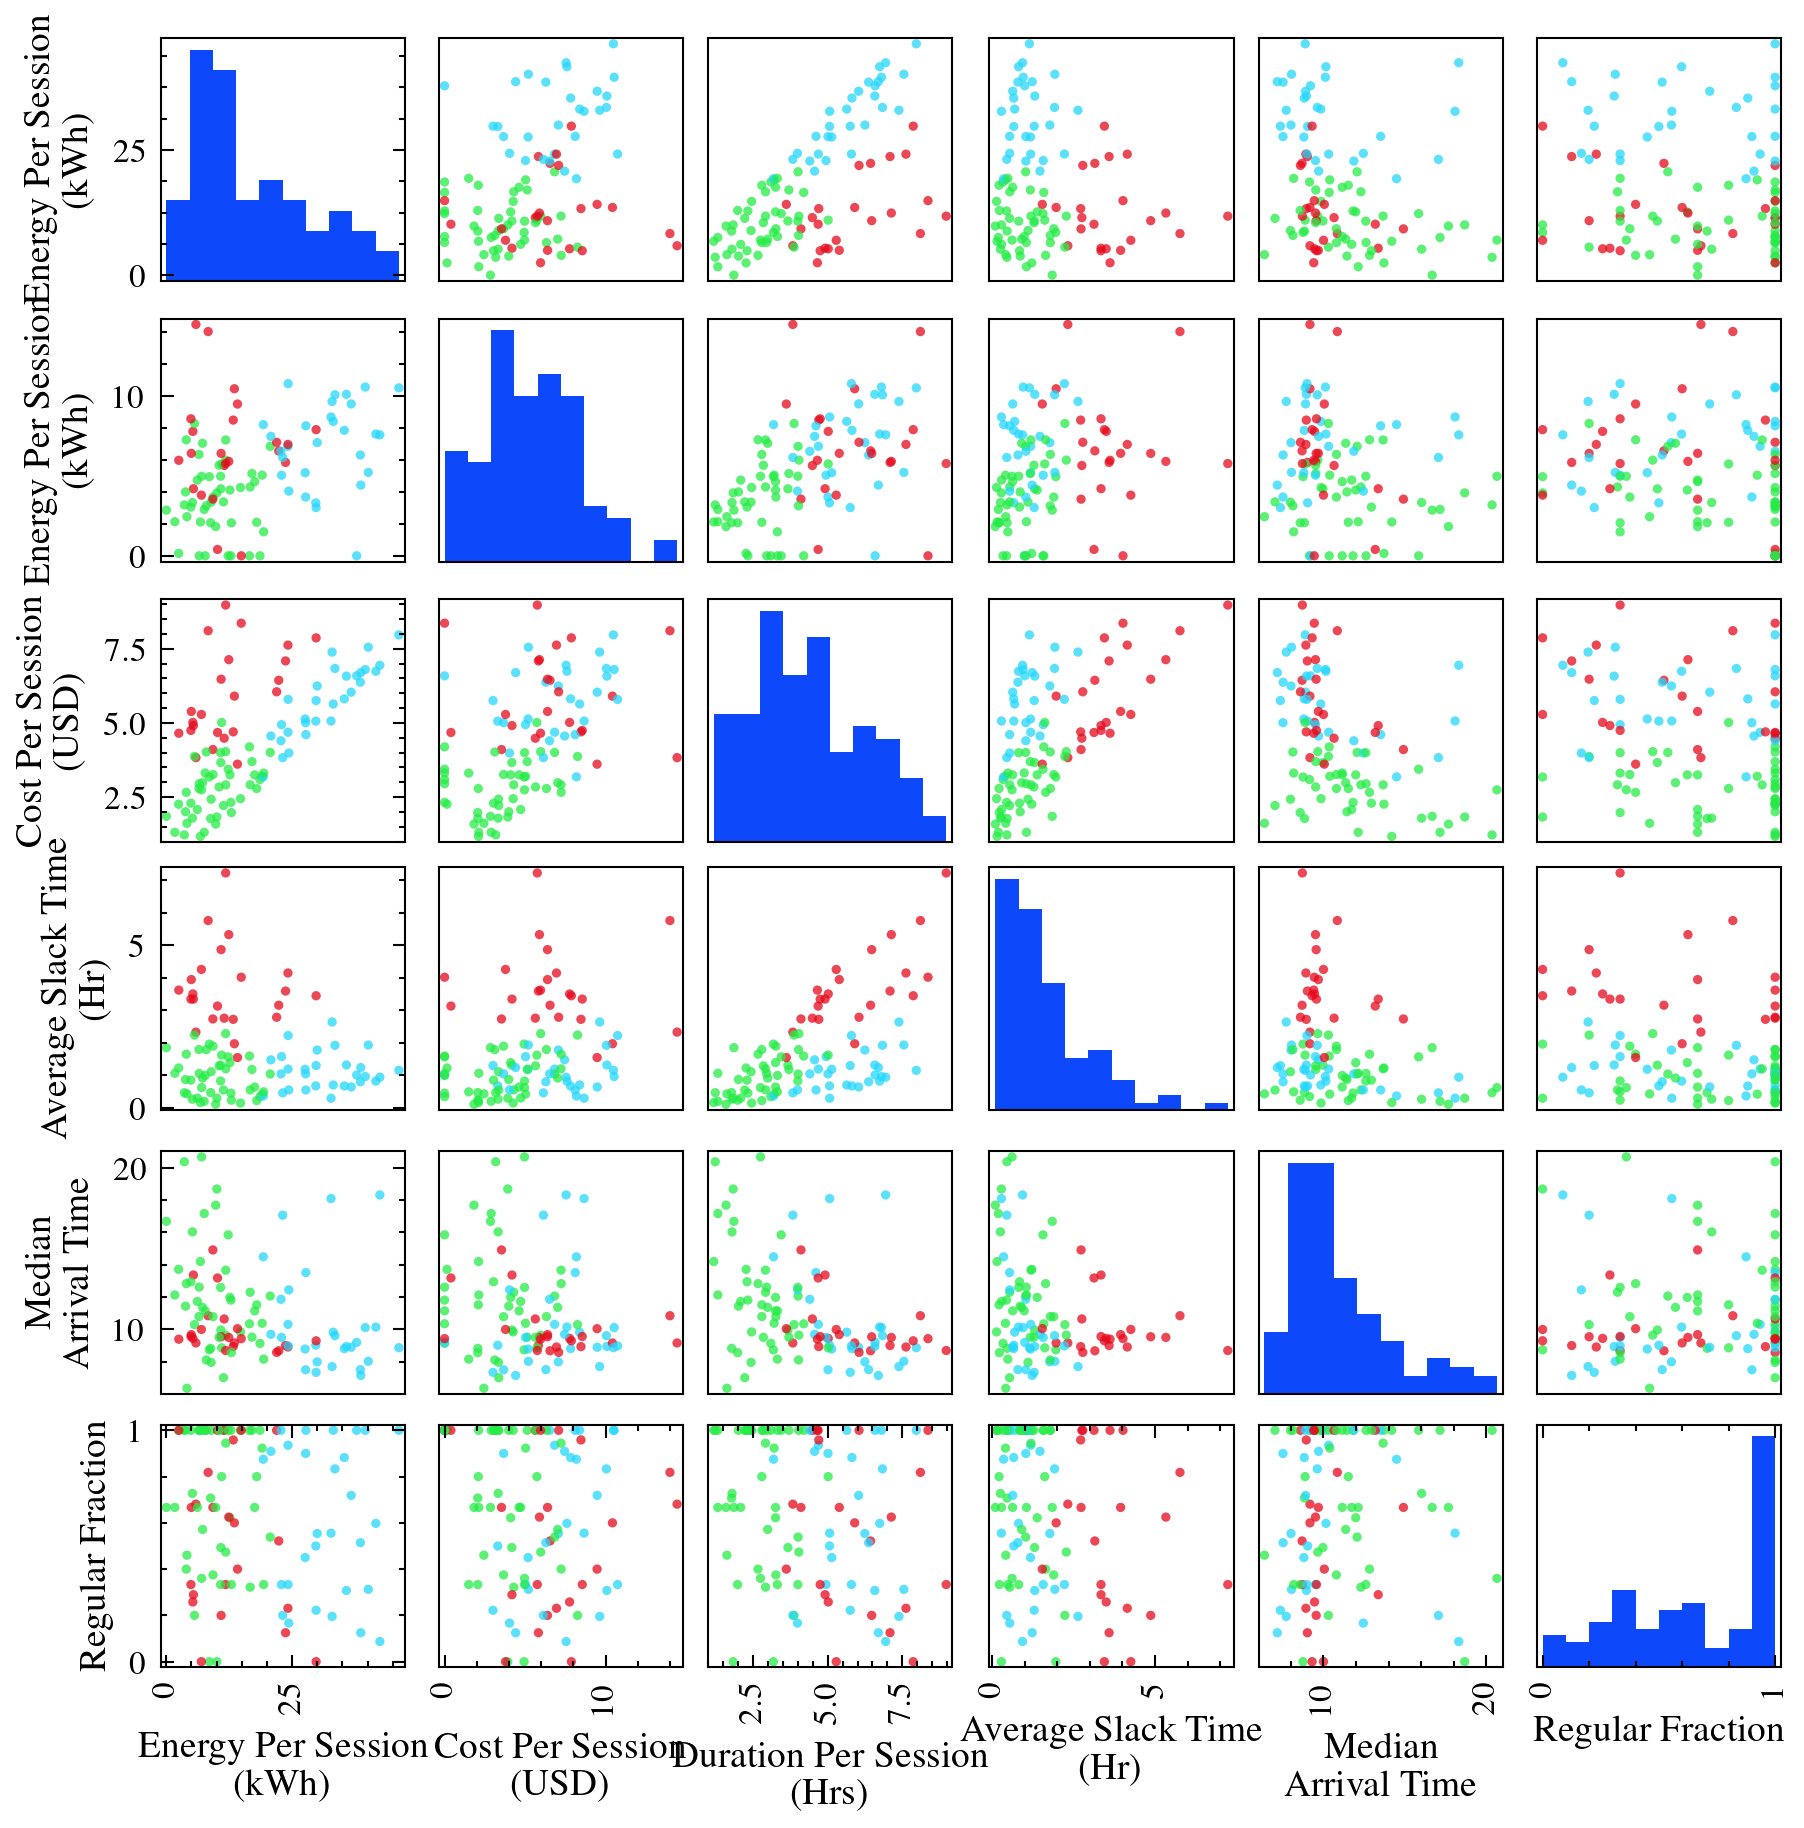

In [80]:
from pandas.plotting import scatter_matrix
df = user_cluster_df[['Energy Per Session\n(kWh)', 'Cost Per Session\n(USD)',
                   'Duration Per Session\n(Hrs)', 'Average Slack Time\n(Hr)',
                   'Median\nArrival Time', 'Regular Fraction']]

fig = plt.figure(tight_layout=True)
axes = scatter_matrix(df, 
                      alpha = 0.75, 
                      figsize = (6, 6), 
                      color = user_cluster_df["color"],
                      s=20 )

# for i in range(np.shape(axes)[0]):
#     for j in range(np.shape(axes)[1]):
#         if i < j:
#             axes[i,j].set_visible(False)
            
axes[1,0].set_ylabel("Energy Per Session\n(kWh)")
axes[2,0].set_ylabel("Cost Per Session\n(USD)")

In [81]:
correction_dict = {
    "Bolt":"Chevy Bolt",
    "Volt":"Chevy Volt",
    "Clarity Plug-In Hybrid":"Honda Clarity PHEV",
    "Clarity PHEV":"Honda Clarity PHEV",
    "Model 3":"Tesla Model 3",
    "Model Y":"Tesla Model Y",
    "Tesla y":"Tesla Model Y",
    "Model X":"Tesla Model X",
    "Model S":"Tesla Model S",
    "Leaf":"Nissan Leaf",
    "Mustang Mach-E":"Ford Mustang Mach-E",
    "Mach-E":"Ford Mustang Mach-E",
    "Niro EV":"Kia Niro EV",
    "Niro":"Kia Niro EV",
    "Taycan": "Porche Taycan",
    "Rav 4":"Toyota Rav4 Prime",
    "RAV4 EV":"Toyota Rav4 EV",
    "Santa Fe PHEV":"Hyundai Santa Fe PHEV",
    "Spark EV":"Chevy Spark EV",
    "500e":"Fiat 500e",
    "Kona":"Hyundai Kona",
    "Crosstrek":"Subaru Crosstrek",
    "e-Golf":"VW e-Golf",
    "XC90 T8":"Volvo XC90 T8",
    "Escape PHEV":"Ford Escape PHEV",
    "Focus Electric":"Ford Focus Electric",
    "Fusion Energi":"Ford Fusion Energi",
    "ID.4":"VW ID.4",
    "ID.3":"VW ID.3",
    "Pacifica Hybrid":"Chrysler Pacifica Hybrid",
    "Ioniq PHEV":"Hyundai Ioniq PHEV",
    "Ioniq Electric":"Hyundai Ioniq EV",
    "Ioniq 5":"Hyundai Ioniq EV",
    'B-Class Electric Drive':"Mercedes B-Class",
    'i3 EV':"BMW i3 EV",
    'i3 REx':"BMW i3 EV",
    'i3 REX (120Ah)':"BMW i3 EV",
    "2":"Polestar 2",
    "C-Max Energi":"Ford C-Max Energi",
    "One":"LiveWire One"
    }
# for key in correction_dict.keys():
#         sessions.loc[sessions.vehicle_model.str.contains(key)] = correction_dict[key]
drop = {'electric drive':np.nan}
sessions['vehicle_model'] = sessions['vehicle_model'].replace(drop)
sessions['vehicle_model'] = sessions['vehicle_model'].replace(correction_dict)

In [82]:
import plotly.graph_objects as go
model_df = sessions.dcosId.groupby(sessions['vehicle_model']).count().sort_index()

fig1 = go.Figure(data=[go.Pie(labels=model_df.index, values=model_df.values)])
fig1.update_layout(
    width=1000,
    height=800,
)
fig1.update_layout(title="Distribution of Sessions by Vehicle Model")
fig1.show()

